In [134]:
#Gives sum of next 30 days output expected
#Try add two years ago as well and see what happens. 
#Add more statistics
#Try polynomial predictor and try LSTM see what happens. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


In [135]:
electricity_ng = pd.read_csv('Dataset/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0': 'Date'})
solar_output = pd.read_csv('Dataset/solarpower_cumuldaybyday2.csv').drop(columns='Unnamed: 2')


In [136]:
def get_month(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    month = date.month
    return month
def get_yr(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    year = date.year
    return year
def get_day(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    day = date.day
    return day

def days_change(x,y):
    date_1 = datetime.strptime(x, "%Y-%m-%d")
    date_2 = datetime.strptime(y, "%Y-%m-%d")
    chng = (date_2 - date_1).days
    return chng

electricity_ng['month'] = electricity_ng['Date'].apply(get_month)
electricity_ng['year'] = electricity_ng['Date'].apply(get_yr)
electricity_ng['yesterday_power'] = electricity_ng['cum_power'].shift(1)
electricity_ng['yesterday'] = electricity_ng['Date'].shift(1)
electricity_ng = electricity_ng.dropna()
electricity_ng
electricity_ng['days'] = electricity_ng.apply(lambda x: days_change(x['yesterday'], x['Date']),axis=1)
electricity_ng['output/day'] = (electricity_ng['cum_power'] - electricity_ng['yesterday_power'])/electricity_ng['days']
electricity_ng['day_of_month'] = electricity_ng['Date'].apply(get_day)



analyze = electricity_ng[['Date','year', 'month', 'day_of_month', 'output/day']]
analyze['target'] = analyze['output/day'].shift(-1)
analyze['target'] = analyze['target'].shift(-30).rolling(window=30).sum()


#analyze.to_csv('check.csv')



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [137]:
def mv_avg(df):
    mvg_avg_lst = [2,3,4,5,7,10,15,20,25,30,45]
    for i in mvg_avg_lst:
        column_name = 'mv_avg_' + str(i)
        df[column_name] = df.iloc[:,4].rolling(window=i).mean()
    return df
# df = mv_avg(analyze)
# df[df['year']==2013]


In [138]:
#Get moving average this time last year and 1 year before for each date
def year_over_yr(data):
    yr = 2011
    yrs = {}
    target = data[['year', 'month', 'day_of_month', 'target']].copy()
    data = data.drop(columns ='target')
    for i in range(0, (max(data['year']) - yr) + 1):
        frame_name = 'year' + str(yr) + 'data' 
        yrs[frame_name] = data[data['year']==yr]
        yr +=1

    
    #Get_last year
    data_set = {}
    for item in [2013,2014,2015,2016,2017,2018,2019]:
        last_yr = item-1
        lst_yr = 'year' + str(last_yr) + 'data' 
        this_yr = 'year' + str(item) + 'data' 
        
        data_last_year = yrs[lst_yr]
        
        
        for column in data_last_year.columns:
            if 'mv_avg' in column:
                data_last_year = data_last_year.rename(columns={column: 'lst_yr_' + str(column)})

        data_this_year = yrs[this_yr]
        iter_frame = pd.DataFrame()
        data_last_year = data_last_year.drop(columns=['Date', 'year', 'output/day'])
        data_this_year =  data_this_year.drop(columns=['Date', 'year'])
        iter_frame = pd.merge(data_this_year,data_last_year, on =['month', 'day_of_month'], how='left')
        iter_frame.insert(0, 'year', item)
        
        data_set[item] = iter_frame

    final_frame = pd.DataFrame()
    i = 0
    for item in data_set.keys():
        if i == 0:
            final_frame = data_set[item]    
            i+=1
            continue
        final_frame = final_frame.append(data_set[item])
  
    final_frame = pd.merge(final_frame,target, on =['year', 'month', 'day_of_month'],how='left')
    final_frame = final_frame.sort_values(by=['year', 'month', 'day_of_month'], ascending=True)
    return final_frame


# df1 = year_over_yr(df)
# df1[(df1['month']==1) & (df1['year']==2013)]


In [248]:
def past_performance(DF):
    past_performance = DF[['year', 'month', 'day_of_month', 'target']]
    past_performance['year+1'] = past_performance['year'] + 1
    past_performance = past_performance[past_performance['year']!=2011]
    past_stats = {}
    for year in list(set(past_performance['year'])):
        if year not in [2011,2012]:
            Frame_name = str(year) + '_pd'
            iter_frame = past_performance[past_performance['year']<year]
            


            past_stats_df = iter_frame[~(iter_frame['target'].isna())].groupby(['month', 'day_of_month'])['target'].agg(['mean', 'std', 'min', 'max']).reset_index()
            last_year = year -1
            last_year_data = iter_frame[iter_frame['year']==last_year]
            last_year_data = last_year_data[['month', 'day_of_month', 'target']]
            last_year_data = last_year_data.rename(columns={'target': 'last_year'})
            put_together = pd.merge(past_stats_df, last_year_data, on =['month', 'day_of_month'],how='left')
            put_together.insert(0, 'year', year)
            past_stats[Frame_name] = put_together
            
    return_this = pd.DataFrame()
    for key in past_stats:
        return_this = return_this.append(past_stats[key])
    return return_this











In [249]:
def day_dums(data):

    data = data[data['year']> 2012]
    day = [0,15,31]
    day_buckets = pd.DataFrame()
    for j in range(0,len(day)):
        start = day[j]
        if j != len(day)-1:
            end = day[j+1]
        else:
            continue
        c_n = 'day>=_' + str(start)+ '_day_<' + str(end)
        day_buckets[c_n] = data.apply(lambda x: 1 if x['day_of_month'] >= start and x['day_of_month'] < end else 0,axis=1)
    day_buckets
    pd.set_option('display.max_rows',300)
    dummies = day_buckets
    merger_data = data[['year', 'month', 'day_of_month']]
    month_dummies = pd.get_dummies(data[data['year']>2012]['month'])
    Trans_frm = merger_data.join(month_dummies)
    Trans_frm = Trans_frm.join(dummies)
    
    return Trans_frm




In [456]:
def pipeline(dataframe):
    dummies = day_dums(dataframe)
    T_1 = mv_avg(dataframe)
    T_2 = year_over_yr(T_1)
    T = pd.merge(dummies, T_2, on=['year', 'month', 'day_of_month'],how='outer')
    past_data = past_performance(DF=analyze)
    T = pd.merge(T, past_data, on =['year','month', 'day_of_month'])
    return T
pd.set_option("display.max_rows",300)


data = pipeline(analyze)
data = data[~(data['std'].isna())]
#display(data.head(5))
lst_yr_ma = []
for column in data.columns:
    if 'lst_yr' in str(column):
        lst_yr_ma.append(column)



train = data[data['year'] < 2019]
#train.to_csv('model_data/train.csv')
train = train[(train['month']!=2) | (train['day_of_month']!= 29)]

test = data[data['year']==2019]


#test.to_csv('model_data/test.csv')
train = train.drop(columns=['year', 'month', 'day_of_month'])
y = train.pop('target')

# test
actual = test.pop('target')
meta = test[['year', 'month', 'day_of_month']]
test = test.drop(columns=['year', 'month', 'day_of_month'])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [482]:
from sklearn.linear_model import LinearRegression


x = train.values
mod = RandomForestRegressor( max_depth=3,max_features=30, min_samples_split=6)
mod.fit(x,y)
mod.score(x, y)


#With linear coeff of determinaton = 0.95

0.9532244168169879

In [483]:

pred = mod.predict(test.values)

In [497]:
anal_ize = pd.DataFrame()
anal_ize['actual'] = actual
anal_ize['predicted'] = pred
anal_ize['error'] = abs(anal_ize['actual'] -anal_ize['predicted'])
anal_ize = meta.join(anal_ize)
anal_ize['error'].sum()
anal_ize = anal_ize.dropna()
anal_ize = anal_ize.reset_index(drop=True)
anal_ize['%err'] = anal_ize['error']/anal_ize['actual']

pd.set_option('display.max_rows',None)
anal_ize




#anal_ize.sort_values(by=['error'],ascending=False)

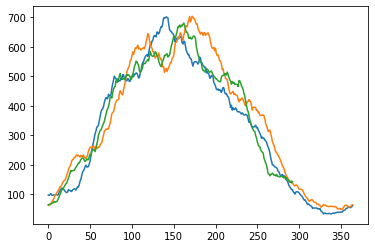

In [500]:

x2017 = data[data['year']==2017].reset_index(drop=True).index
y2017 = data[data['year']==2017]['target']

x2018 = data[data['year']==2018].reset_index(drop=True).index
y2018 = data[data['year']==2018]['target']


x2019 = anal_ize.index
y2019 = anal_ize['actual']



plt.plot(x2017,y2017)
plt.plot(x2018,y2018)
plt.plot(x2019,y2019)


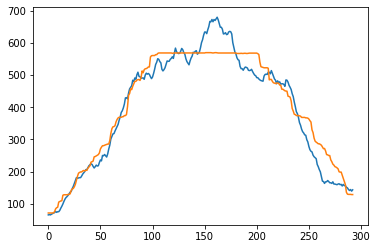

In [485]:
# x = anal_ize['actual']
x = anal_ize.index
y1 = anal_ize['actual']
y2 = anal_ize['predicted']




plt.plot(x,y1)
plt.plot(x,y2)




In [486]:
anal_ize['%err'] = anal_ize['error']/anal_ize['actual']
anal_ize['%err'].mean()
#anal_ize[anal_ize['month']==6]

0.1092957632868363

,year,month,day_of_month,1,2,3,4,5,6,7,8,9,10,11,12,day>=_0_day_<15,day>=_15_day_<31,output/day,mv_avg_2,mv_avg_3,mv_avg_4,mv_avg_5,mv_avg_7,mv_avg_10,mv_avg_15,mv_avg_20,mv_avg_25,mv_avg_30,mv_avg_45,lst_yr_mv_avg_2,lst_yr_mv_avg_3,lst_yr_mv_avg_4,lst_yr_mv_avg_5,lst_yr_mv_avg_7,lst_yr_mv_avg_10,lst_yr_mv_avg_15,lst_yr_mv_avg_20,lst_yr_mv_avg_25,lst_yr_mv_avg_30,lst_yr_mv_avg_45,target,mean,std,min,max,last_year
365,2014,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2.0,2.0,2.666667,2.75,2.4,2.571429,2.10,2.466667,2.80,3.00,3.033333,2.777778,1.75,2.133333,1.850,1.76,1.785714,1.49,1.413333,1.620,1.836,1.780000,2.031111,80.0,70.100000,13.859293,60.3,79.9,60.3
366,2014,1,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,2.5,2.333333,2.75,2.8,2.714286,2.30,2.600000,2.80,3.04,3.000000,2.822222,1.90,2.066667,2.275,2.02,1.857143,1.74,1.526667,1.515,1.876,1.770000,2.068889,81.0,72.050000,18.879751,58.7,85.4,58.7
367,2014,1,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2.0,2.5,2.333333,2.25,2.6,2.428571,2.32,2.466667,2.65,3.04,2.900000,2.822222,2.55,2.066667,2.150,2.30,1.985714,1.95,1.600000,1.490,1.776,1.836667,2.084444,83.0,78.650000,20.435386,64.2,93.1,64.2
368,2014,1,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,2.5,2.666667,2.50,2.4,2.714286,2.60,2.400000,2.55,2.96,2.966667,2.866667,1.50,1.900000,1.700,1.84,1.871429,1.82,1.500000,1.480,1.788,1.796667,2.055556,90.0,79.600000,18.526198,66.5,92.7,66.5
369,2014,1,5,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,2.0,2.000000,2.25,2.2,2.428571,2.50,2.133333,2.50,2.80,2.966667,2.844444,0.50,1.133333,1.525,1.44,1.785714,1.64,1.486667,1.430,1.748,1.783333,1.968889,93.0,85.000000,19.374726,71.3,98.7,71.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,2019,11,16,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2.0,2.5,2.666667,3.75,3.2,4.000000,4.20,4.066667,4.65,5.12,4.800000,5.088889,5.50,5.666667,4.750,4.20,3.857143,4.20,4.800000,4.800,4.680,4.900000,6.955556,NaN,74.314286,15.490581,54.0,101.0,73.0
2511,2019,11,17,0,0,0,0,0,0,0,0,0,0,1,0,0,1,4.0,3.0,3.000000,3.00,3.8,3.857143,4.20,4.200000,4.50,4.96,4.700000,4.977778,3.50,4.000000,4.500,4.00,3.285714,3.80,4.733333,4.450,4.400,4.733333,6.844444,NaN,73.742857,15.416318,54.0,100.0,72.0
2512,2019,11,18,0,0,0,0,0,0,0,0,0,0,1,0,0,1,3.0,3.5,3.000000,3.00,3.0,3.285714,4.20,4.133333,4.45,4.80,4.800000,4.955556,3.50,4.333333,4.500,4.80,4.000000,4.20,4.533333,4.400,4.400,4.800000,6.644444,NaN,72.257143,15.823912,54.0,98.0,67.0
2513,2019,11,19,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.0,1.5,2.333333,2.25,2.4,3.142857,3.50,4.000000,4.15,4.48,4.633333,4.888889,6.50,4.666667,5.000,5.00,4.714286,4.10,4.533333,4.650,4.600,4.866667,6.533333,NaN,72.714286,17.133926,51.0,99.0,67.0
